In [87]:
from __future__ import print_function    # (at top of module)
import warnings
warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

# Initial preparations

In [193]:
# Read the data from the file
data = pd.read_csv('Data/data_500_entries_youtube.csv')
# data = pd.read_csv('Data/data_3000_entries_youtube.csv')

print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


In [90]:
from project_modules import *

# Depending on the dataset we have different ways of labeling the data
if 'total_no_streams' in data.columns:
    # In the 3000 song dataset there are 3 features that can be used for 
    # labeling : popularity, total_no_streams, youtube_view_count
    data = data[data.popularity > 10]
    data = data[data.total_no_streams > 999999]
    data = data[data.youtube_view_count > 999999]
    final_data = label_data_combined(data, 89, 700000000, 700000000)
else:
    # In the 500 song dataset, there are 2 features that can be used for
    # labeling : popularity and youtube_view_count
    final_data = label_data_yt(data, 89, 1000000000)

Number of popular examples after thresholding :  59
Number of not popular examples after thresholding :  511


In [91]:
# Drop unnecessary text columns or columns used for labeling from data
if 'total_no_streams' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_view_count', 'youtube_video_title', 'total_no_streams'], 1, inplace=True)
else:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_view_count', 'youtube_video_title'], 1, inplace=True) 

In [92]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']

# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


In [202]:
# We split the data into :
# X_cv - will be used for cross validation
# X_test - will be used to test the model after the CV, on data that is
#          unseen -> test how well the model will do in the real world
from sklearn.model_selection import train_test_split
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print("Items in CV data set : ", str(len(X_cv.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in CV data set :  456
Items in testing data set:  114


In [203]:
# Those are the columns of features that will be used for prediction
# in our data
COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode"]

In [204]:
from sklearn import preprocessing

# We initialize a scaler
scaler = preprocessing.StandardScaler()

# Fit the scaler to our data
scaler.fit(X_cv)

# Scale both our data sets and keep them in pandas DataFrames
X_cv = pd.DataFrame(scaler.transform(X_cv), columns=COLUMNS_TO_SCALE)
X_test = pd.DataFrame(scaler.transform(X_test), columns=COLUMNS_TO_SCALE)

C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rares\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Rares\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


# Declare models

In [198]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Here we declare the models that we want to use
# Each model has a title, the actual instance of the model and a 
# list of features to use
# If the feature list is 'all' instead, all features will be used

# Models with selected features
models_with_features = [
           {'title':"Gaussian Naive Bayes", 'model':GaussianNB(), 'feature_set':'all'},
           {'title':"Logistic regression", 'model':LogisticRegression(solver='lbfgs', random_state=3), 'feature_set':'all'},
           {'title':"Logistic regression balanced weights", 'model':LogisticRegression(solver='lbfgs',class_weight='balanced', random_state=3), 'feature_set':['energy', 'tempo', 'instrumentalness', 'danceability', 'loudness', 'valence']},
           {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',random_state=3)), 'feature_set':['energy', 'danceability', 'loudness', 'valence']},
           {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=3)), 'feature_set':'all'},
           {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':'all'},
           {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 1)), 'feature_set':['energy', 'liveness', 'acousticness', 'instrumentalness', 'danceability', 'loudness', 'valence']},
           {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':'all'},
           {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':['energy', 'tempo', 'speechiness', 'instrumentalness', 'time_signature', 'duration', 'loudness']},
           {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':['energy', 'tempo', 'speechiness', 'loudness', 'valence']},
           {'title':"Multilayer Perceptron", 'model':MLPClassifier(learning_rate="constant", solver="adam", alpha=0.001, activation="relu", random_state=1), 'feature_set':['energy', 'liveness', 'tempo', 'acousticness', 'instrumentalness', 'time_signature', 'duration', 'loudness', 'valence']},
           {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(solver="lbfgs", activation="relu", alpha=0.00001, learning_rate="adaptive",random_state=3, hidden_layer_sizes=(50, 100, 50))), 'feature_set':'all'},
           {'title':"MLP Online", 'model':MLPClassifier(activation = 'relu', solver='sgd', alpha=1, random_state=3), 'feature_set':['energy', 'liveness', 'tempo', 'acousticness', 'instrumentalness', 'time_signature', 'duration', 'loudness', 'valence']},
           {'title':"MLP Online Oversampling", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(activation = 'relu', solver='sgd', alpha=0.0001, learning_rate="constant")), 'feature_set':'all'},
           {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced"), 'feature_set':['liveness', 'acousticness', 'instrumentalness', 'time_signature', 'danceability', 'duration', 'valence', 'mode']},
           {'title':"AdaBoost", 'model':AdaBoostClassifier(n_estimators=100), 'feature_set':'all'}
           ]
# Models using all the features
models = [
           {'title':"Gaussian Naive Bayes", 'model':GaussianNB(), 'feature_set':'all'},
           {'title':"Logistic regression", 'model':LogisticRegression(solver='lbfgs', random_state=3), 'feature_set':'all'},
           {'title':"Logistic regression balanced weights", 'model':LogisticRegression(solver='lbfgs',class_weight='balanced', random_state=3), 'feature_set':'all'},
           {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',random_state=3)), 'feature_set':'all'},
           {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=3)), 'feature_set':'all'},
           {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':'all'},
           {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17)), 'feature_set':'all'},
           {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':'all'},
           {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':'all'}, 
           {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':'all'},
           {'title':"Multilayer Perceptron", 'model':MLPClassifier(activation = 'relu', solver='lbfgs', alpha=1, random_state=3), 'feature_set':'all'},
           {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(activation = 'relu', solver='lbfgs', alpha=0.0001, random_state=3, learning_rate='adaptive')), 'feature_set':'all'},
           {'title':"MLP Online", 'model':MLPClassifier(activation = 'relu', solver='sgd', alpha=1, random_state=3), 'feature_set':'all'},
           {'title':"MLP Online Oversampling", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(activation = 'relu', solver='sgd', alpha=0.0001, learning_rate="constant")), 'feature_set':'all'},
           {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=13, random_state=3, class_weight="balanced"), 'feature_set':'all'},
           {'title':"AdaBoost", 'model':AdaBoostClassifier(n_estimators=100), 'feature_set':'all'},
           {'title':"SGDClassifier", 'model':SGDClassifier(max_iter=1000, tol=1e-3, loss="log"), 'feature_set':'all'}
         ]

# Columns for the stats(scoring) that we will use to compare our models
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC", "Generalized AUC"]

# Cross Validation

In [208]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# Define main cross validation function
# Input parameters are the models dictionary, number of folds for CV,
# data for cv, labels for cv data, data for test, labels for test data
def cv_models(models, cv_folds, X_cv, y_cv, X_test, y_test):
    # Average ROC curve code from here https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    
    # Initialize cross validation strategy
    cv = StratifiedShuffleSplit(n_splits=cv_folds, random_state=5)
    
    # Array for all the different scoring
    cv_stats = []
    
    # For every model in the model dictionary
    for item in models:
        # Print name of the current model
        print(item['title'])
        
        # Initialize classifier
        classifier = item['model']
        
        tprs = []
        aucs = []
        accs = []
        specificities = []
        recalls = []
        precisions = []
        f1s = []
        
        # Return 100 evenly spaced numbers between 0 and 1
        mean_fpr = np.linspace(0, 1, 100)
        
        # Current fold number
        i = 0
        
        # Current feature set to be used
        cur_feature_set=item['feature_set']
        
        if(cur_feature_set == 'all'):
            # In this case we use all the features
            # Also, transform dataset to numpy array for faster processing
            X_with_sel_features=np.array(X_cv)
            cur_feature_set= COLUMNS_TO_SCALE
        else:
            # In thise case we use the features specified
            X_with_sel_features=np.array(X_cv[cur_feature_set])
            
        # Also transform labels to numpy array
        y_cv = np.array(y_cv)
        
        # For each fold of Cross Validation
        for train, test in cv.split(X_with_sel_features, y_cv):
            
            # Get the prediction probabilities for the current fold
            predicted_probabilities = classifier.fit(X_with_sel_features[train], y_cv[train]).predict_proba(X_with_sel_features[test])
            
            # Get predicted labels for current fold
            predicted_labels = classifier.predict(X_with_sel_features[test])
            
            # Compute false positive rate, true positive rates and thresholds
            # To compute those we use the current test labels and the predicted
            # probabilities
            fpr, tpr, thresholds = roc_curve(y_cv[test], predicted_probabilities[:, 1])
            
            # Interpolate values to generate curve for plotting
            tprs.append(interp(mean_fpr, fpr, tpr))
            
            # Make sure curve starts from 0
            tprs[-1][0] = 0.0
            
            # Calculate area under the ROC curve
            roc_auc = auc(fpr, tpr)
            
            # Get the confusion matrix
            conf_matrix = confusion_matrix(y_cv[test], predicted_labels)
            
            # Keep AUC scores for each folds
            aucs.append(roc_auc)
            
            # Keep accuracies for each fold
            accs.append(accuracy_score(y_cv[test], predicted_labels))
            
            # Keep specificities for each fold
            specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
            
            # Keep recalls for each fold
            recalls.append(recall_score(y_cv[test], predicted_labels))
            
            # Keep precisions for each fold
            precisions.append(precision_score(y_cv[test], predicted_labels))
            
            # Keep F1 scores for each fold
            f1s.append(f1_score(y_cv[test], predicted_labels))
            
            # Plot current fold
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            i += 1
        # Plot line for a random predictor
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                 label='Chance', alpha=.8)

        # Average true positive rates for folds
        mean_tpr = np.mean(tprs, axis=0)
        # Make sure we start from 0
        mean_tpr[-1] = 1.0
        # Average AUC score
        mean_auc = auc(mean_fpr, mean_tpr)
        # Calculate AUC standard deviation
        std_auc = np.std(aucs)
        
        # Plot mean curve across all folds
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)
        # Calculated true positive standard deviation
        std_tpr = np.std(tprs, axis=0)
        # Upper and lower curves
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        
        # Plot standard deviation
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
        
        # Extend plot area
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        # Label plot
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for ' + item['title'])
        plt.legend(loc="lower right")
        plt.show()
        
        # Fit the model with all the CV data
        item['model'].fit(X_with_sel_features, y_cv)
        # Predict test data and calculate new score
        # This score represents how well our model works in the real world
        y_pred_prob = item['model'].predict_proba(X_test[cur_feature_set])[:,1]
        test_after_auc = roc_auc_score(y_test, y_pred_prob)
        
        # Keep scores for current model
        newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc, test_after_auc]
        cv_stats.append(newRow)
    # Add all the scores to a DataFrame so we can display nicely
    stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
    return stats_df

# Run CV

Logistic regression balanced weights


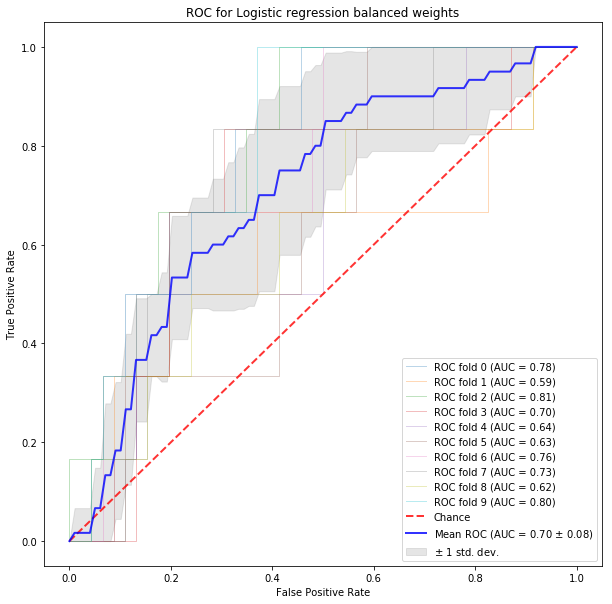

Accuracy mean:  0.6346153846153846

Oversampling logistic regression


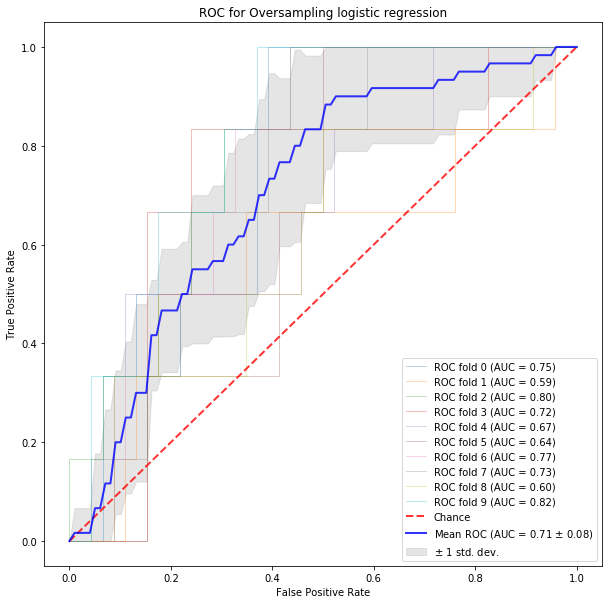

Accuracy mean:  0.6576923076923077

SVM balanced weights


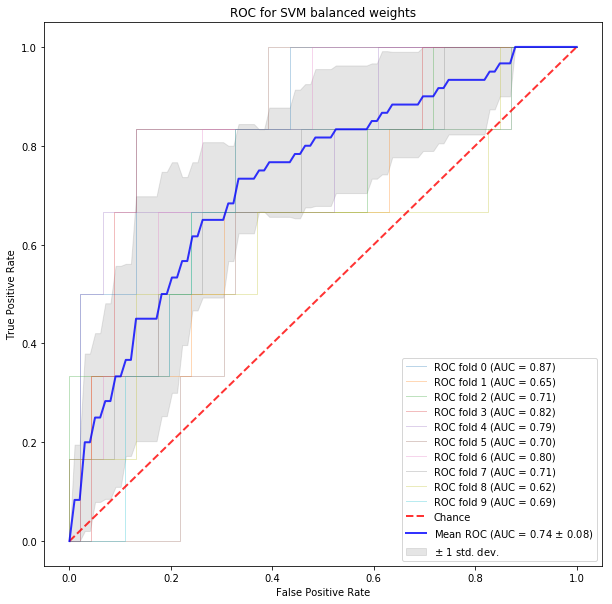

Accuracy mean:  0.7096153846153846

Oversampling SVM


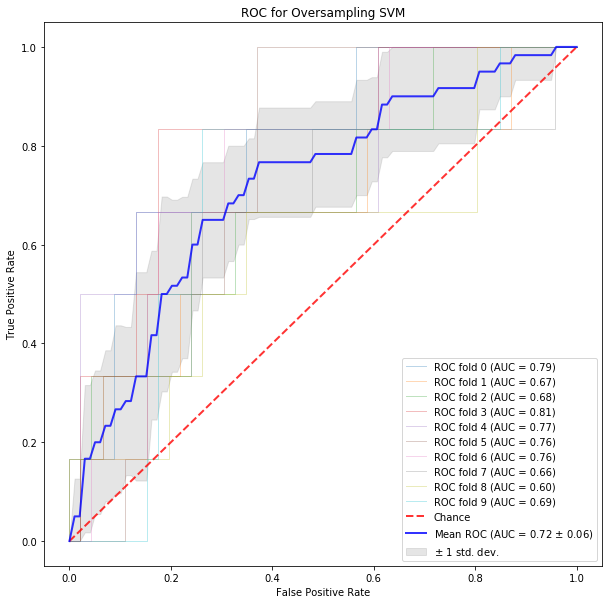

Accuracy mean:  0.7673076923076922

Multilayer Perceptron


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


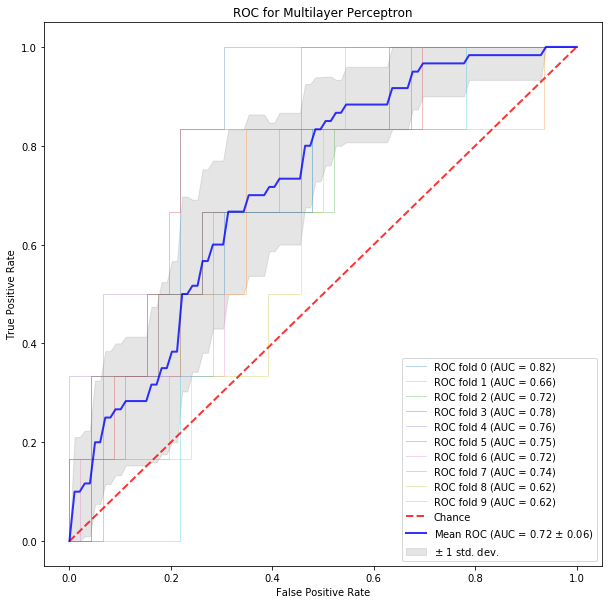

Accuracy mean:  0.8673076923076923

Oversampling Multilayer Perceptron


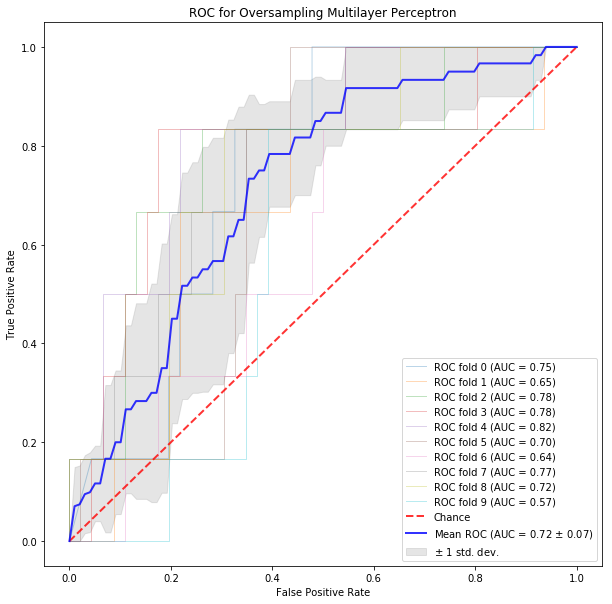

Accuracy mean:  0.825



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC,Generalized AUC
0,Logistic regression balanced weights,0.634615,0.628261,0.683333,0.196475,0.304136,0.704882,0.254717
1,Oversampling logistic regression,0.657692,0.652174,0.700000,0.212419,0.323994,0.709259,0.283019
2,SVM balanced weights,0.709615,0.708696,0.716667,0.243692,0.362422,0.736364,0.433962
3,Oversampling SVM,0.767308,0.800000,0.516667,0.246169,0.329381,0.718182,0.471698
4,Multilayer Perceptron,0.867308,0.960870,0.150000,0.266667,0.190000,0.718013,0.415094
5,Oversampling Multilayer Perceptron,0.825000,0.906522,0.200000,0.217778,0.201284,0.716384,0.523585


In [200]:
# Run with dictionary with all features
stats1 = cv_models(models, 10, X_cv, y_cv, X_test, y_test)
stats1.head(20)

SVM balanced weights


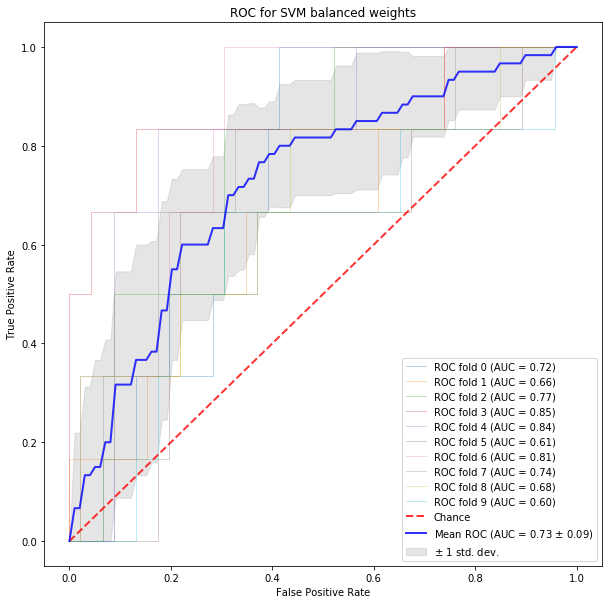

Accuracy mean:  0.6250000000000001

Multilayer Perceptron


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Rares\Anaconda3\lib\site-pack

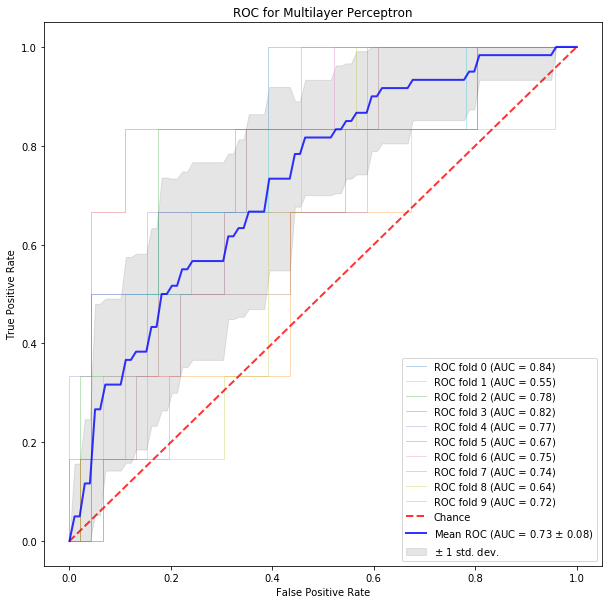

Accuracy mean:  0.8826923076923077



C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Oversampling Multilayer Perceptron


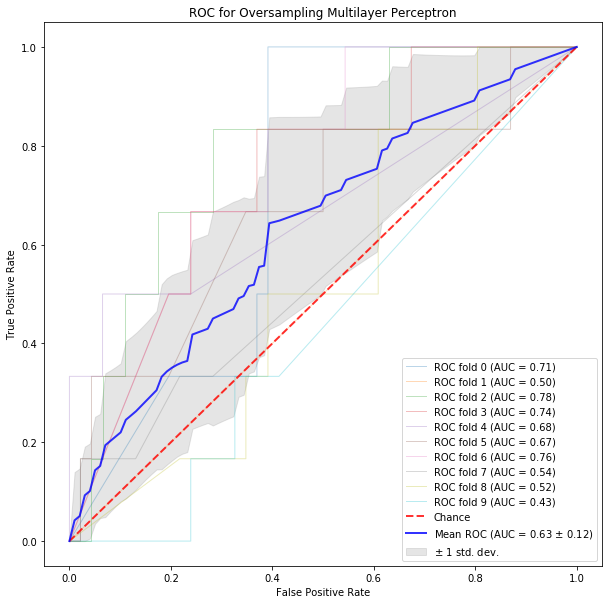

Accuracy mean:  0.6692307692307693



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC,Generalized AUC
0,SVM balanced weights,0.625000,0.606522,0.766667,0.205915,0.322647,0.726431,0.382075
1,Multilayer Perceptron,0.882692,0.997826,0.000000,0.000000,0.000000,0.726936,0.353774
2,Oversampling Multilayer Perceptron,0.669231,0.697826,0.450000,0.171077,0.231115,0.633069,0.367925


In [201]:
# Run with dictionary with selected features
stats2 = cv_models(models_with_features, 10, X_cv, y_cv, X_test, y_test)
stats2.head(20)